<a href="https://colab.research.google.com/github/call493/MLFC/blob/main/_notebooks/Poverty_and_Literacy_levels_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the link between literacy rates and poverty in Kenya - A Soci-Economic Analysis



---



Braxton Mandara, DSAIL

15-09-2025

# **OSMnx Setup**

Installing Python packages which we will use to download, model and analyze map features and other spatial data from OpenStreetMap.*italicized text*



In [1]:
%%capture
%pip install osmnx

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

Downloading data for Kenya

In [ ]:
place_name = "Nyeri, Kenya"
latitude = -0.4371
longitude = 36.9580
placestub = place_name.lower().replace(' ', '-').replace(',','')

Bounding box for Kenya:
Min Longitude (minx): 33.9096888
Min Latitude (miny): -4.8995204
Max Longitude (maxx): 41.9067502
Max Latitude (maxy): 4.62


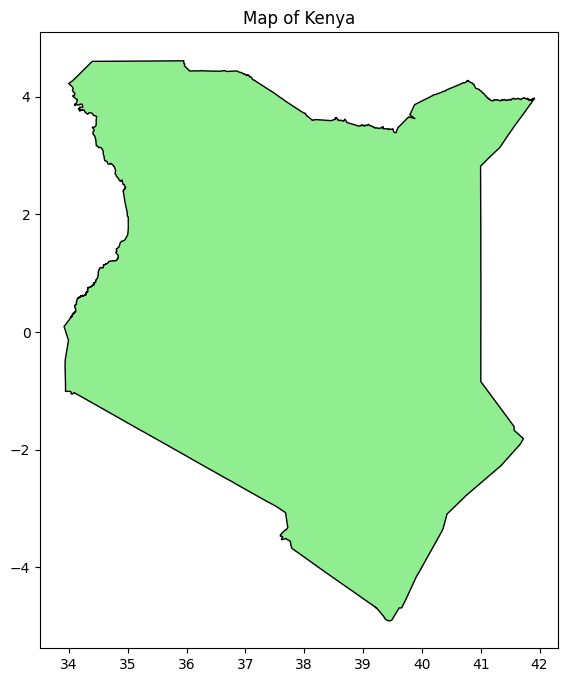

In [4]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define the place name
place_name = "Kenya"

# Download the boundary polygon for Kenya
boundary = ox.geocode_to_gdf(place_name)

# Extract the bounding box coordinates
minx, miny, maxx, maxy = boundary.total_bounds

print(f"Bounding box for Kenya:")
print(f"Min Longitude (minx): {minx}")
print(f"Min Latitude (miny): {miny}")
print(f"Max Longitude (maxx): {maxx}")
print(f"Max Latitude (maxy): {maxy}")

# Plot the map of Kenya
fig, ax = plt.subplots(figsize=(8, 8))
boundary.plot(ax=ax, color='lightgreen', edgecolor='black')
ax.set_title('Map of Kenya')
plt.show()

Show Counties and road networks in Kenya

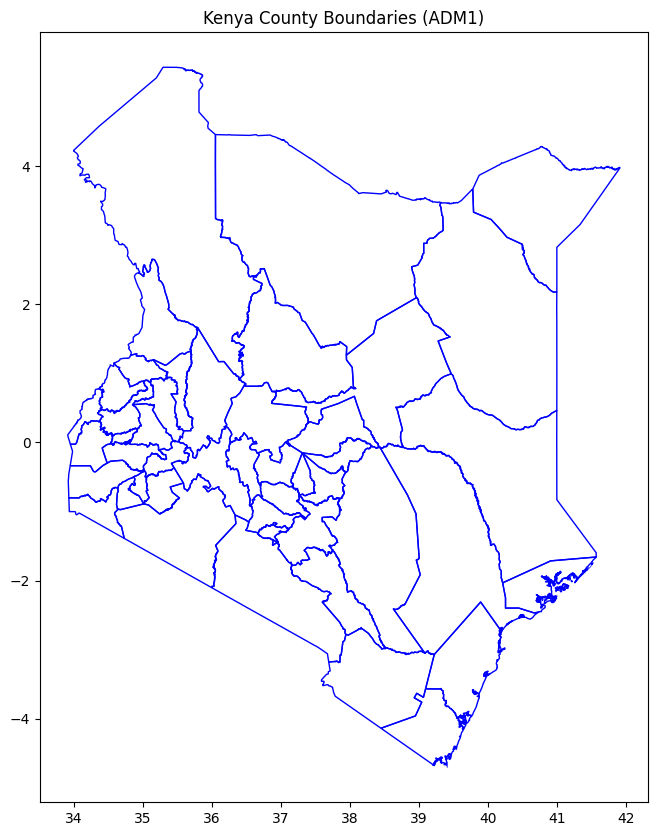

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

# URL to the GeoJSON file for Kenyan counties (ADM1) from GeoBoundaries
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

# Load GeoJSON data into a GeoDataFrame
gdf = gpd.read_file(geojson_url)

# Plot the boundaries
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

ax.set_title("Kenya County Boundaries (ADM1)")

plt.show()